# Import Libraries

In [1]:
!pip uninstall -y transformers
!pip install --no-cache-dir transformers

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 192.7 MB/s eta 0:00:00


In [2]:
# Install required libraries (Uncomment these if not already installed)
!pip install datasets peft accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing ins

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset, Dataset
from peft import LoraConfig, get_peft_model, TaskType, PrefixTuningConfig
import evaluate
import torch
import re
import numpy as np
import json
from transformers import TrainerCallback
import matplotlib.pyplot as plt

2025-05-30 08:59:56.593991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748595596.781175      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748595596.836791      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Data Preparation
Task: Text Generation

Dataset: Alpaca

We split 90% for training and validating, 10% for testing.

In the 90% for train and validation, continue to split 80% for training and 20% for validating.

In [4]:
!wget https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json

--2025-05-30 09:00:11--  https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22773992 (22M) [text/plain]
Saving to: ‘alpaca_data.json’

alpaca_data.json    100%[===================>]  21.72M  --.-KB/s    in 0.1s    

2025-05-30 09:00:12 (198 MB/s) - ‘alpaca_data.json’ saved [22773992/22773992]



In [5]:

# Load JSON manually
with open("alpaca_data.json", "r") as f:
    raw_data = json.load(f)

# # Subsample for low compute
# raw_data = raw_data[:1000]

# Clean text
def clean_text(text):
    return re.sub(r"\s+", " ", text.strip())

# Reformat and clean
cleaned_data = [
    {
        "prompt": clean_text(x["instruction"] + " " + x["input"] if x["input"] else x["instruction"]),
        "response": clean_text(x["output"])
    }
    for x in raw_data
]

# Convert to HF Dataset
dataset = Dataset.from_list(cleaned_data)

# Format for language modeling
def format_sample(example):
    return {
        "text": f"### Prompt:\n{example['prompt']}\n\n### Response:\n{example['response']}"
    }
dataset = dataset.map(format_sample)

# Now split the dataset: shuffle first
dataset = dataset.shuffle(seed=42)

# Split 10% test, 90% rest
test_size = int(0.1 * len(dataset))
test_dataset = dataset.select(range(test_size))
rest_dataset = dataset.select(range(test_size, len(dataset)))

# Split rest into 80% train, 20% validation
train_size = int(0.8 * len(rest_dataset))
train_dataset = rest_dataset.select(range(train_size))
valid_dataset = rest_dataset.select(range(train_size, len(rest_dataset)))

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Tokenize all splits (batched)
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
valid_dataset = valid_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

Train size: 37441
Validation size: 9361
Test size: 5200


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/37441 [00:00<?, ? examples/s]

Map:   0%|          | 0/9361 [00:00<?, ? examples/s]

Map:   0%|          | 0/5200 [00:00<?, ? examples/s]

# 2. Fine-tuning

3 fine-tuning methods:


1. LoRA
2. Prefix
3. Adapter



In [6]:
# Define base model
base_model = AutoModelForCausalLM.from_pretrained("gpt2")

# Data collator for Causal LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Evaluation metric
perplexity_metric = evaluate.load("perplexity", module_type="metric")

def compute_perplexity(model, dataset):
    model.eval()
    losses = []
    for i in range(0, len(dataset), 10):
        batch = dataset[i:i+10]
        inputs = tokenizer(batch["text"], return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            loss = model(**inputs, labels=inputs["input_ids"]).loss
        losses.append(loss.item())
    return float(np.exp(np.mean(losses)))


logs_lora = []
logs_adapter = []
logs_prefix = []

class CustomLogger(TrainerCallback):
    def __init__(self, log_store):
        self.log_store = log_store

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            logs["epoch"] = int(state.epoch) if state.epoch is not None else None
            self.log_store.append(logs)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

## LORA
* r = 4
* alpha = 16
* drop_out = 0.1
* batch_size = 16
* num_epochs = 16

In [8]:
# --- 1. LoRA ---
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)
model_lora = get_peft_model(base_model, lora_config)
trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[CustomLogger(logs_lora)]
)
trainer_lora.train()

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/tmp/ipykernel_19/528005853.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.471400,2.246918
2,2.331600,2.204396
3,2.305100,2.185839
4,2.294500,2.176933
5,2.288800,2.173367


TrainOutput(global_step=11705, training_loss=2.338280582550192, metrics={'train_runtime': 12206.0624, 'train_samples_per_second': 15.337, 'train_steps_per_second': 0.959, 'total_flos': 4.899997587603456e+16, 'train_loss': 2.338280582550192, 'epoch': 5})

## Prefix-tuning
* num_virtual_toke = 10
* drop_out = 0.1
* batch_size = 16
* num_epochs = 16

In [9]:
# --- 2. Prefix-Tuning ---
prefix_config = PrefixTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=10
)
model_prefix = get_peft_model(base_model, prefix_config)
trainer_prefix = Trainer(
    model=model_prefix,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[CustomLogger(logs_prefix)]
)
trainer_prefix.train()

/tmp/ipykernel_19/497455960.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_prefix = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,6.143100,4.347829
2,4.857800,3.635845
3,4.346000,3.243509
4,4.074700,3.068623
5,3.956100,3.013210


TrainOutput(global_step=11705, training_loss=4.675525032705041, metrics={'train_runtime': 12421.0186, 'train_samples_per_second': 15.072, 'train_steps_per_second': 0.942, 'total_flos': 4.899997587603456e+16, 'train_loss': 4.675525032705041, 'epoch': 5})

## Adapter

We use LORA to mimic the behavior of classic adapter for better efficiency by:
* Attaching LoRA modules only to specific layers (e.g., attention or feedforward layers),
* Freezing the base model weights and only training the LoRA parameters,
* Using larger LoRA rank (r) and optionally non-zero scaling factors, to allow for a richer representation similar to adapter modules.

Hyper-parameters:
* r = 8
* alpha = 32
* drop_out = 0.05
* batch_size = 16
* num_epochs = 16

In [10]:
# --- 3. Adapter-Tuning (emulated using LoRA with adapter-like config) ---
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType

# Define Adapter-like LoRA config
adapter_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,                  # Higher rank to simulate adapter depth
    lora_alpha=32,        # Stronger scaling
    lora_dropout=0.05,    # Mild regularization
    bias="none"
)

# Reload a fresh base model to avoid conflicts
adapter_model = AutoModelForCausalLM.from_pretrained("gpt2")
model_adapter = get_peft_model(adapter_model, adapter_config)
# Define trainer with train and validation sets
trainer_adapter = Trainer(
    model=model_adapter,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[CustomLogger(logs_adapter)]
)
# Train
trainer_adapter.train()

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/tmp/ipykernel_19/2274317909.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_adapter = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,2.431500,2.222344
2,2.308600,2.181185
3,2.281300,2.160762
4,2.269900,2.152439
5,2.263800,2.148910


TrainOutput(global_step=11705, training_loss=2.3110192626014525, metrics={'train_runtime': 12200.7961, 'train_samples_per_second': 15.344, 'train_steps_per_second': 0.959, 'total_flos': 4.908477690150912e+16, 'train_loss': 2.3110192626014525, 'epoch': 5})

In [11]:
print("\nAll models trained: LoRA, Prefix-Tuning, Prompt-Tuning")


All models trained: LoRA, Prefix-Tuning, Prompt-Tuning


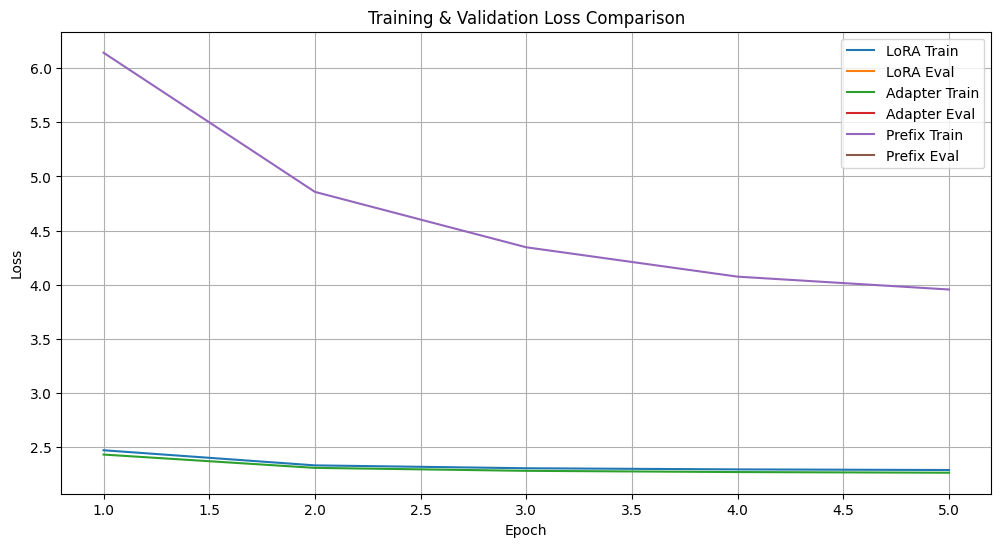

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss(logs, label):
    df = pd.DataFrame(logs)

    if "loss" in df.columns:
        df_loss = df.dropna(subset=["loss"])
        plt.plot(df_loss["epoch"], df_loss["loss"], label=f"{label} Train")

    if "eval_loss" in df.columns:
        df_eval = df.dropna(subset=["eval_loss"])
        plt.plot(df_eval["epoch"], df_eval["eval_loss"], label=f"{label} Eval")

plt.figure(figsize=(12, 6))

plot_loss(logs_lora, "LoRA")
plot_loss(logs_adapter, "Adapter")
plot_loss(logs_prefix, "Prefix")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


Since the dataset is not too large, it is reasonable that after 5 epochs, validation losses decrease very slowly

# 3. Evaluation

Perplexity is used as the metrics to evaluate the performance. For text generation, good perplexity usually correlates with more fluent, coherent, and natural text. From the resulted perplexity scores, there are a few things that can be pointed out. 

1. LORA 

Only a minor improvement over the base model. 

Possible reasons:

* The LoRA rank (r) may be too small, limiting capacity.

* Not enough training steps or data.

* LoRA might not have been applied to the most effective layers.

--> LoRA is powerful, but needs careful hyperparameter tuning — especially rank and alpha — and proper placement

2. Prefix-tuning

Huge improvement over the base model (1375.56 --> 375.32).

Indicates that prefix-tuning adapted the model effectively to the task.

3. Adapter Tuning:

Worse than the base model.

Suggests that the adapter: 

* Did not converge well.

* Possibly introduced optimization difficulties or model mismatch.


Additional in4:
- Training time: 11h on P100

In [13]:
# Evaluate base model before fine-tuning
base_model.eval()
# Evaluate after fine-tuning
eval_base = compute_perplexity(base_model, test_dataset)
eval_lora = compute_perplexity(model_lora, test_dataset)
eval_prefix = compute_perplexity(model_prefix, test_dataset)
eval_adapter = compute_perplexity(model_adapter, test_dataset)
print("Before fine-tuning Perplexity:", eval_base)
print("LoRA:", eval_lora)
print("Prefix", eval_prefix)
print("Adapter:", eval_adapter)

Before fine-tuning Perplexity: 1375.559084515623
LoRA: 1373.3550098673036
Prefix 375.32275354096623
Adapter: 1487.177672173883


In [14]:
# Save LoRA model
trainer_lora.model.save_pretrained("./lora_model")
tokenizer.save_pretrained("./lora_model")

# Save Prefix model
trainer_prefix.model.save_pretrained("./prefix_model")
tokenizer.save_pretrained("./prefix_model")

# Save Adapter model
trainer_adapter.model.save_pretrained("./adapter_model")
tokenizer.save_pretrained("./adapter_model")

('./adapter_model/tokenizer_config.json',
 './adapter_model/special_tokens_map.json',
 './adapter_model/vocab.json',
 './adapter_model/merges.txt',
 './adapter_model/added_tokens.json',
 './adapter_model/tokenizer.json')